ค่าเฉลี่ย (Mean): 12.09 วัน
ค่ามัธยฐาน (Median): 10.00 วัน


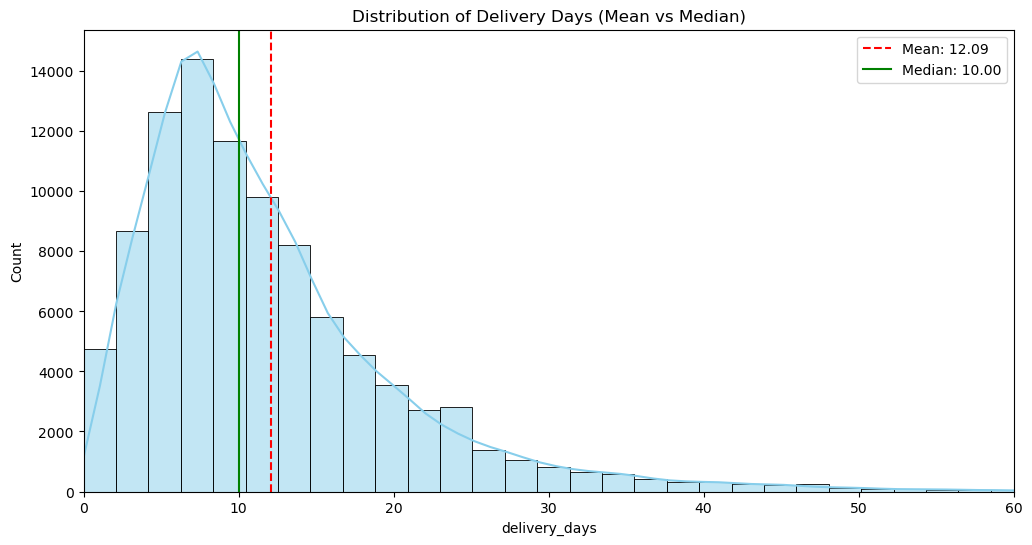

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# โหลดข้อมูลดิบ (เหมือนการเอาน้ำมันเครื่องมาเช็ค)
df = pd.read_csv('C:/Users/user/AppData/Local/vscode-sqltools/Data/session/olist_raw_delivery.csv')


# แปลงข้อมูลวันที่ (เพิ่ม errors='coerce' เพื่อจัดการวันที่ 0000-00-00)
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'], errors='coerce')
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'], errors='coerce')

# กรองแถวที่กลายเป็นค่าว่างออกไป เพื่อไม่ให้คำนวณผิด
df = df.dropna(subset=['order_purchase_timestamp', 'order_delivered_customer_date'])

# คำนวณ "จำนวนวันส่งจริง" (เหมือนเดิม)
df['delivery_days'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

# หา "ค่าเฉลี่ย" VS "ค่ามัธยฐาน (ตรงกลาง)"
mean_val = df['delivery_days'].mean()
median_val = df['delivery_days'].median()

print(f"ค่าเฉลี่ย (Mean): {mean_val:.2f} วัน")
print(f"ค่ามัธยฐาน (Median): {median_val:.2f} วัน")

# พลอตกราฟดูการกระจายตัว (ดูว่า Outlier อยู่ไหน)
plt.figure(figsize=(12, 6))
sns.histplot(df['delivery_days'], bins=100, kde=True, color='skyblue')

# ใส่เส้นชี้วัด
plt.axvline(mean_val, color='red', linestyle='--', label=f'Mean: {mean_val:.2f}')
plt.axvline(median_val, color='green', linestyle='-', label=f'Median: {median_val:.2f}')

plt.title('Distribution of Delivery Days (Mean vs Median)')
plt.xlim(0, 60) # ดูแค่ 60 วันแรกก่อน เพราะ Outlier ไกลมาก!
plt.legend()
plt.show()

In [14]:
# คำนวณหาค่า Q1, Q3 และ IQR
Q1 = df['delivery_days'].quantile(0.25)
Q3 = df['delivery_days'].quantile(0.75)
IQR = Q3 - Q1

# ตั้งรั้วขอบเขต
lower_fence = Q1 - 1.5 * IQR
upper_fence = Q3 + 1.5 * IQR

# กรองข้อมูล เอาเฉพาะที่อยู่ "ในรั้ว" (Inliers)
df_clean = df[(df['delivery_days'] >= lower_fence) & (df['delivery_days'] <= upper_fence)]

# เปรียบเทียบผลลัพธ์
print(f"ก่อนกรอง: Mean = {df['delivery_days'].mean():.2f} วัน")
print(f"หลังกรอง (Clean): Mean = {df_clean['delivery_days'].mean():.2f} วัน")
print(f"ค่ามัธยฐาน (Median): {df_clean['delivery_days'].median():.2f} วัน")
print(f"เรากำจัด Outliers ไปทั้งหมด: {len(df) - len(df_clean)} รายการ")

ก่อนกรอง: Mean = 12.09 วัน
หลังกรอง (Clean): Mean = 10.56 วัน
ค่ามัธยฐาน (Median): 9.00 วัน
เรากำจัด Outliers ไปทั้งหมด: 5022 รายการ


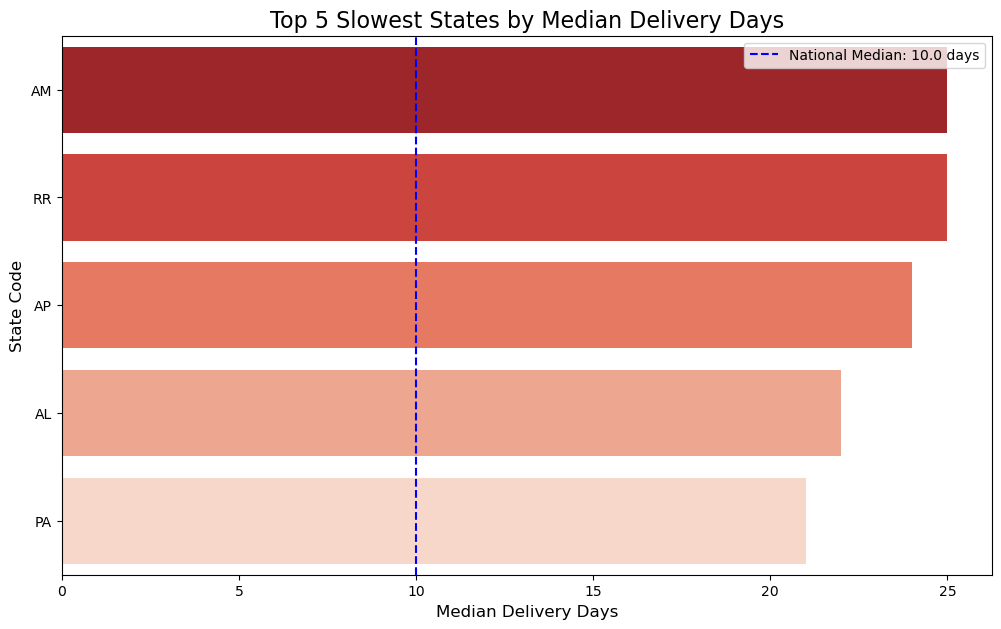

--- TOP 5 Delay! ---
customer_state
AM    25.0
RR    25.0
AP    24.0
AL    22.0
PA    21.0
Name: delivery_days, dtype: float64


In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# โหลดข้อมูล
df_state = pd.read_csv('C:/Users/user/AppData/Local/vscode-sqltools/Data/session/olist_state_delivery.csv')
df_state['order_purchase_timestamp'] = pd.to_datetime(df_state['order_purchase_timestamp'], errors='coerce')
df_state['order_delivered_customer_date'] = pd.to_datetime(df_state['order_delivered_customer_date'], errors='coerce')

# คำนวณวันส่งของ
df_state['delivery_days'] = (df_state['order_delivered_customer_date'] - df_state['order_purchase_timestamp']).dt.days
df_state = df_state.dropna(subset=['delivery_days'])

# จัดกลุ่มหารัฐที่ "ส่งช้าที่สุด" 5 อันดับแรก (ใช้ Median!)
state_performance = df_state.groupby('customer_state')['delivery_days'].median().sort_values(ascending=False).head(5)

# พลอตกราฟชี้เป้า
plt.figure(figsize=(12, 7))
sns.barplot(x=state_performance.values, y=state_performance.index, hue=state_performance.index, palette='Reds_r', legend=False)

plt.title('Top 5 Slowest States by Median Delivery Days', fontsize=16)
plt.xlabel('Median Delivery Days', fontsize=12)
plt.ylabel('State Code', fontsize=12)

# ใส่เส้นค่าเฉลี่ยทั้งประเทศเพื่อเปรียบเทียบ
overall_median = df_state['delivery_days'].median()
plt.axvline(overall_median, color='blue', linestyle='--', label=f'National Median: {overall_median} days')
plt.legend()

plt.show()

print("--- TOP 5 Delay! ---")
print(state_performance)

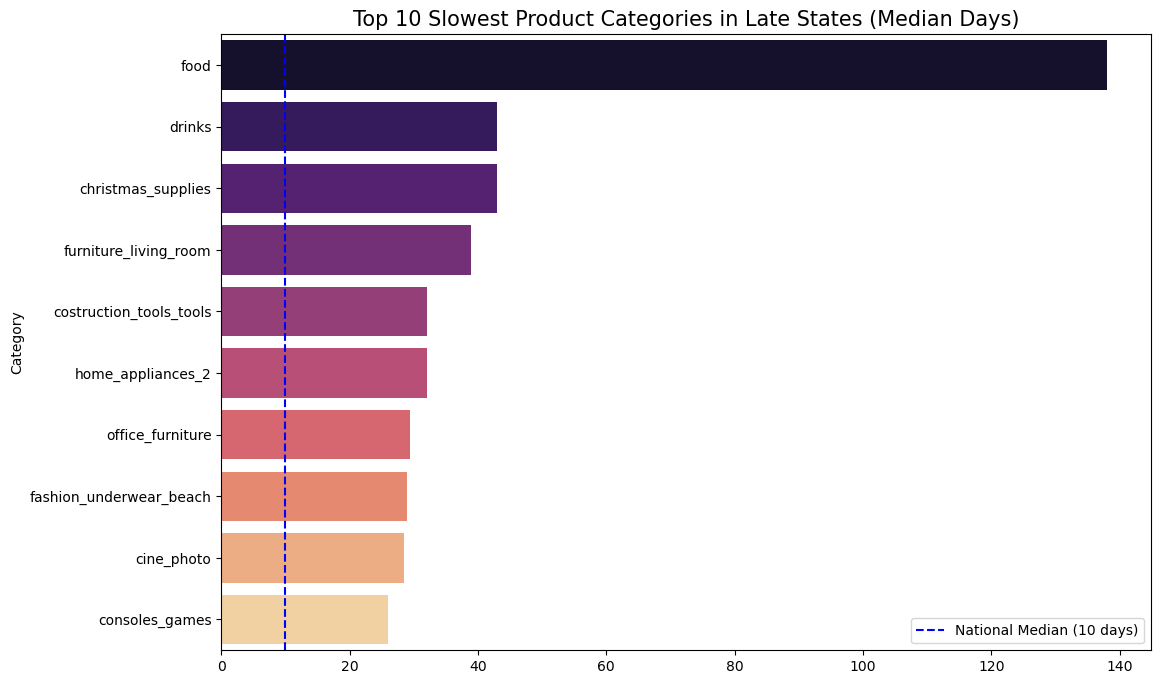

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# โหลดข้อมูล
df_prod = pd.read_csv('C:/Users/user/AppData/Local/vscode-sqltools/Data/session/olist_late_states_products.csv')
df_prod['delivery_days'] = (pd.to_datetime(df_prod['order_delivered_customer_date']) - 
                            pd.to_datetime(df_prod['order_purchase_timestamp'])).dt.days

# ล้างตัวอักษรลับที่อาจติดมาในชื่อ Category
df_prod['Category'] = df_prod['Category'].str.strip()

# จัดกลุ่มใหม่ 
prod_rank = df_prod.groupby('Category')['delivery_days'].median().sort_values(ascending=False).head(10)

# วาดกราฟ 
plt.figure(figsize=(12, 8))
sns.barplot(x=prod_rank.values, y=prod_rank.index, hue=prod_rank.index, palette='magma', legend=False)

plt.title('Top 10 Slowest Product Categories in Late States (Median Days)', fontsize=15)
plt.axvline(10, color='blue', linestyle='--', label='National Median (10 days)')
plt.legend()
plt.show()